# EDA

EDA is performed on the Spider [dataset](https://drive.google.com/uc?export=download&id=1TqleXec_OykOYFREKKtschzY29dUcVAQ). More info about the datset [here](https://yale-lily.github.io/spider).

In [1]:
import os
from google.cloud import storage

client = storage.Client()
bucket = client.bucket(os.environ['SPIDER_BUCKET'])

Let's start by looking at the structure of each of the files.

In [2]:
list(bucket.list_blobs())

[<Blob: spider-dataset, README.txt, 1681622518089506>,
 <Blob: spider-dataset, database/.DS_Store, 1681622521156940>,
 <Blob: spider-dataset, database/academic/academic.sqlite, 1681622657658468>,
 <Blob: spider-dataset, database/academic/schema.sql, 1681622657582045>,
 <Blob: spider-dataset, database/activity_1/activity_1.sqlite, 1681622925832035>,
 <Blob: spider-dataset, database/activity_1/schema.sql, 1681622925147576>,
 <Blob: spider-dataset, database/aircraft/aircraft.sqlite, 1681622564895220>,
 <Blob: spider-dataset, database/aircraft/schema.sql, 1681622564697063>,
 <Blob: spider-dataset, database/allergy_1/allergy_1.sqlite, 1681622677941722>,
 <Blob: spider-dataset, database/allergy_1/schema.sql, 1681622677631188>,
 <Blob: spider-dataset, database/apartment_rentals/apartment_rentals.sqlite, 1681622929354553>,
 <Blob: spider-dataset, database/apartment_rentals/schema.sql, 1681622928786884>,
 <Blob: spider-dataset, database/architecture/architecture.sqlite, 1681622676023303>,
 <Blo

As the Spider info page describes, the json files contain records containing the following fields:

- `db_id`: the database id to which this question is addressed.
- `query`: the SQL query corresponding to the question.
- `query_toks`: the SQL query tokens corresponding to the question.
- `query_toks_no_value`: list of tokens for the query, where the values are mapped to the keyword `value`.
- `question`: the natural language question.
- `question_toks`: list of tokens for the natural language question.
- `sql`: parsed results of this SQL query using [process_sql.py](https://github.com/taoyds/spider/blob/master/process_sql.py). 

In [5]:
train_spider = bucket.get_blob('train_spider.json').download_as_text()
train_spider.split('\n')[:200]

['[',
 '    {',
 '        "db_id": "department_management",',
 '        "query": "SELECT count(*) FROM head WHERE age  >  56",',
 '        "query_toks": [',
 '            "SELECT",',
 '            "count",',
 '            "(",',
 '            "*",',
 '            ")",',
 '            "FROM",',
 '            "head",',
 '            "WHERE",',
 '            "age",',
 '            ">",',
 '            "56"',
 '        ],',
 '        "query_toks_no_value": [',
 '            "select",',
 '            "count",',
 '            "(",',
 '            "*",',
 '            ")",',
 '            "from",',
 '            "head",',
 '            "where",',
 '            "age",',
 '            ">",',
 '            "value"',
 '        ],',
 '        "question": "How many heads of the departments are older than 56 ?",',
 '        "question_toks": [',
 '            "How",',
 '            "many",',
 '            "heads",',
 '            "of",',
 '            "the",',
 '            "departments",',
 '       

It's unclear what `train_others.json` is used for, but `train_spider.json` is the training set, and `dev.json` is the validation set. We will explore this further later.

It's unclear what the sql files are used for. They seem to align with the `query` field in the `.json` files. Let's verify this.

In [7]:
train_gold = bucket.get_blob('train_gold.sql').download_as_text()
train_gold.split('\n')[:200]

['SELECT count(*) FROM head WHERE age  >  56\tdepartment_management',
 'SELECT name ,  born_state ,  age FROM head ORDER BY age\tdepartment_management',
 'SELECT creation ,  name ,  budget_in_billions FROM department\tdepartment_management',
 'SELECT max(budget_in_billions) ,  min(budget_in_billions) FROM department\tdepartment_management',
 'SELECT avg(num_employees) FROM department WHERE ranking BETWEEN 10 AND 15\tdepartment_management',
 "SELECT name FROM head WHERE born_state != 'California'\tdepartment_management",
 "SELECT DISTINCT T1.creation FROM department AS T1 JOIN management AS T2 ON T1.department_id  =  T2.department_id JOIN head AS T3 ON T2.head_id  =  T3.head_id WHERE T3.born_state  =  'Alabama'\tdepartment_management",
 'SELECT born_state FROM head GROUP BY born_state HAVING count(*)  >=  3\tdepartment_management',
 'SELECT creation FROM department GROUP BY creation ORDER BY count(*) DESC LIMIT 1\tdepartment_management',
 "SELECT T1.name ,  T1.num_employees FROM departm

In [8]:
lines = train_gold.split('\n')
len(lines)

8660

In [9]:
import json

train_spider = json.loads(train_spider)
len(train_spider)

7000

It already seems like there is a discrepancy, as `train_spider.json` has less records that `train_gold.sql`. It's possible, `train_others.json` might have the remaining records.

In [10]:
import json

train_others = json.loads(bucket.get_blob('train_others.json').download_as_text())
len(train_others)

1659

Seems like the full training corpus includes records from both `train_spider.json` and `train_others.json`. Now, let's verify that `train_gold.sql` aligns with the `query` field in the `.json` files.

In [11]:
gold_queries = [line.split('\t')[0] for line in lines]
train_spider_queries = [record['query'] for record in train_spider]
gold_queries[:len(train_spider_queries)] == train_spider_queries

False

In [12]:
p = 0
for i, (gold, train) in enumerate(zip(gold_queries[:len(train_spider_queries)], train_spider_queries)):
    if p > 10:
        break
    if gold != train:
        print(i)
        print(gold)
        print(train)
        p += 1

20
SELECT Hosts FROM farm_competition WHERE Theme != 'Aliens'
SELECT Hosts FROM farm_competition WHERE Theme !=  'Aliens'
21
SELECT Hosts FROM farm_competition WHERE Theme != 'Aliens'
SELECT Hosts FROM farm_competition WHERE Theme !=  'Aliens'
54
SELECT Census_Ranking FROM city WHERE Status != "Village"
SELECT Census_Ranking FROM city WHERE Status !=  "Village"
55
SELECT Census_Ranking FROM city WHERE Status != "Village"
SELECT Census_Ranking FROM city WHERE Status !=  "Village"
165
SELECT count(*) FROM trip AS T1 JOIN station AS T2 ON T1.end_station_id  =  T2.id WHERE T2.city != "San Francisco"
SELECT count(*) FROM trip AS T1 JOIN station AS T2 ON T1.end_station_id  =  T2.id WHERE T2.city !=  "San Francisco"
789
SELECT city_name FROM city WHERE population  =  ( SELECT MAX ( population ) FROM city WHERE state_name  =  "wyoming" ) AND state_name  =  "wyoming";
SELECT count(*) FROM member WHERE Membership_card  =  'Black'
790
SELECT city_name FROM city WHERE population  =  ( SELECT MAX (

`train_gold.sql` seems to disagree with the training data. Even though the number of records is equal to the sum of the number of records in `train_spider.json` and `train_others.json`, it seems to have records in a different order. According to the Spider GitHub [page](https://github.com/taoyds/spider), it's used for evaluation to compare the predicted sql to the true sql. This can probably be generated from the `.json` files depending on how we decide to create our trainining, validation, and testing splits. We can proceed by ignoring this file for now.

Let's continue by structuring our data.


In [13]:
import json

dev = json.loads(bucket.get_blob('dev.json').download_as_text())
len(dev)

1034

In [34]:
dev[0]

{'db_id': 'concert_singer',
 'query': 'SELECT count(*) FROM singer',
 'query_toks': ['SELECT', 'count', '(', '*', ')', 'FROM', 'singer'],
 'query_toks_no_value': ['select', 'count', '(', '*', ')', 'from', 'singer'],
 'question': 'How many singers do we have?',
 'question_toks': ['How', 'many', 'singers', 'do', 'we', 'have', '?'],
 'sql': {'from': {'table_units': [['table_unit', 1]], 'conds': []},
  'select': [False, [[3, [0, [0, 0, False], None]]]],
  'where': [],
  'groupBy': [],
  'having': [],
  'orderBy': [],
  'limit': None,
  'intersect': None,
  'union': None,
  'except': None}}

In [73]:
data = train_spider + train_others + dev
question_toks = [rec['question_toks'] for rec in data]
query_toks = [rec['query_toks_no_value'] for rec in data]
db_id = [rec['db_id'] for rec in data]

assert len(question_toks) == len(query_toks) == len(db_id)

In [81]:
import pandas as pd
df = pd.DataFrame({'db': db_id, 'question_toks': question_toks, 'query_toks': query_toks})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9693 entries, 0 to 9692
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   db             9693 non-null   object
 1   question_toks  9693 non-null   object
 2   query_toks     9693 non-null   object
dtypes: object(3)
memory usage: 227.3+ KB


Let's build some visualizations to better understand our data, now that it's structured.

In [75]:
import plotly.express as px

In [76]:
db_freqs = df['db'].value_counts(ascending=False)
top5_db_vals = db_freqs.iloc[:8].values.tolist() + [db_freqs.iloc[5:].sum()]
top5_db_labs = [lab.title() for lab in db_freqs.iloc[:8].index.tolist()] + ['Others']

fig = px.pie(values=top5_db_vals, names=top5_db_labs, title='Proportion of Records by Database Name')
fig

In [100]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

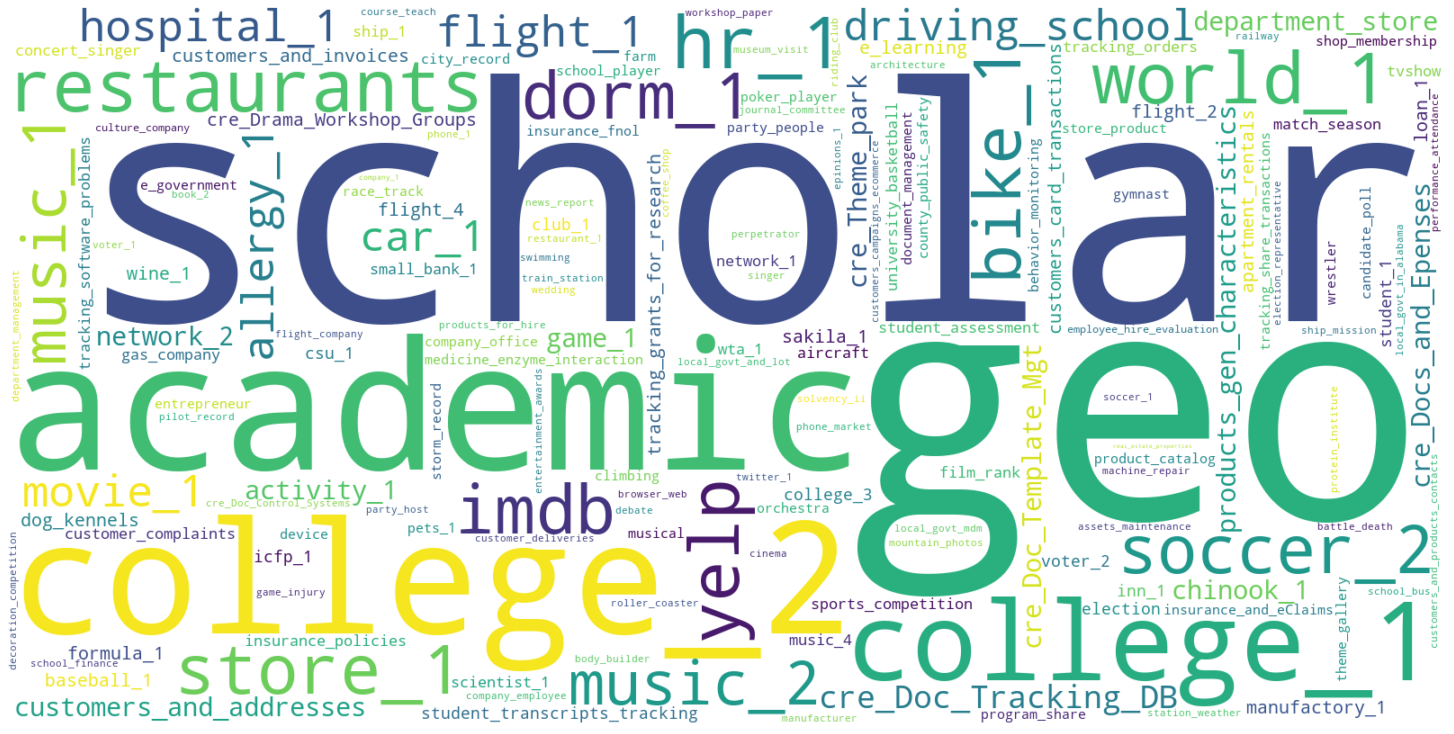

In [119]:
wc = WordCloud(background_color='white', width=1600, height=800).generate_from_frequencies(db_freqs.to_dict())
plt.figure(figsize=(20, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)

In [130]:
fig = px.violin(df['query_toks'].map(len), orientation='h', box=True, title='Distribution of # of Tokens in Queries')
fig.update_xaxes(title='PDF')
fig.update_yaxes(title='Attribute')

In [131]:
fig = px.violin(df['question_toks'].map(len), orientation='h', box=True, title='Distribution of # of Tokens in Questions')
fig.update_xaxes(title='PDF')
fig.update_yaxes(title='Attribute')

**Wordcloud Portraying Tokens in Natural Language Questions**

In [152]:
all_question_toks = pd.Series(sum(df['question_toks'].tolist(), []))
all_question_toks = all_question_toks.map(lambda x: x.lower())

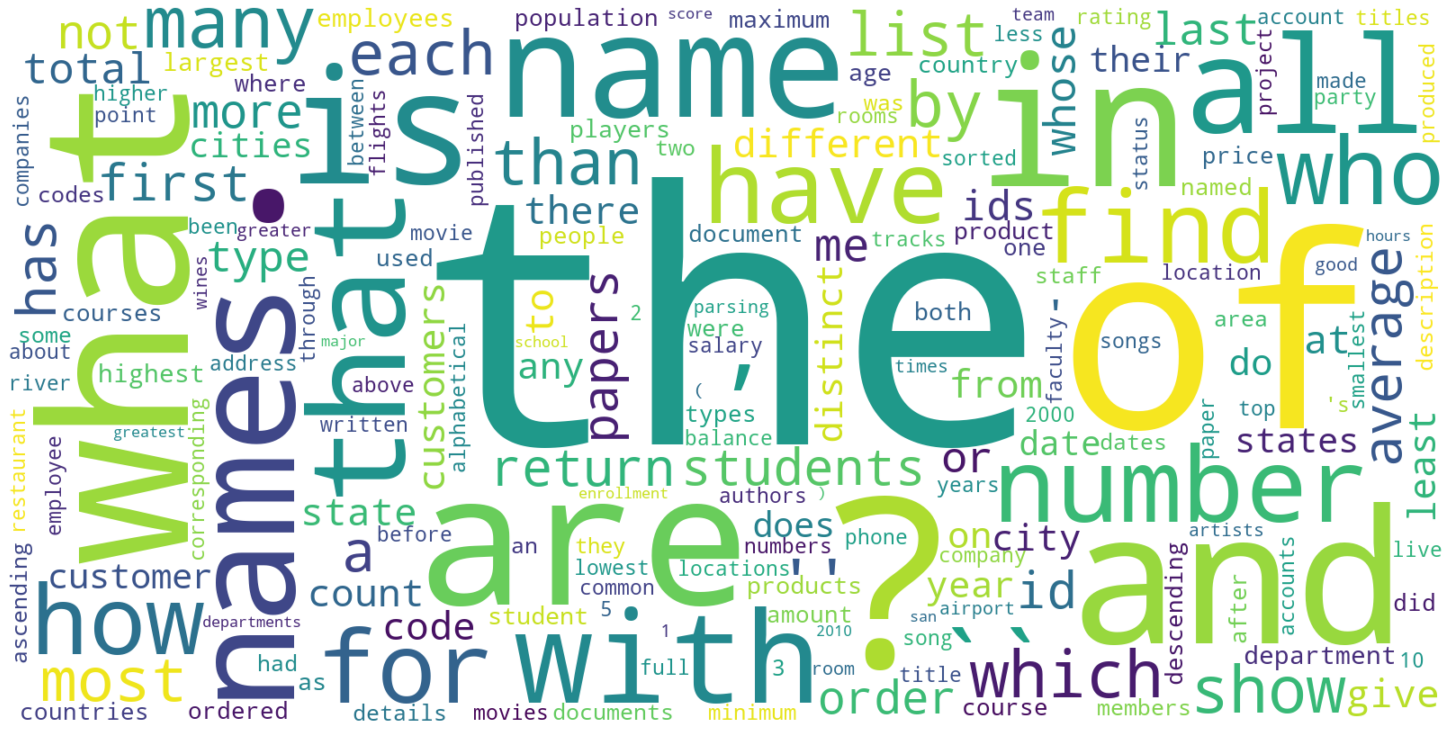

In [153]:
wc = WordCloud(background_color='white', width=1600, height=800).generate_from_frequencies(all_question_toks.value_counts().to_dict())
plt.figure(figsize=(20, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)

**Wordcloud Portraying Tokens in SQL Queries**

In [154]:
all_query_toks = pd.Series(sum(df['query_toks'].tolist(), []))
all_query_toks = all_query_toks.map(lambda x: x.lower())

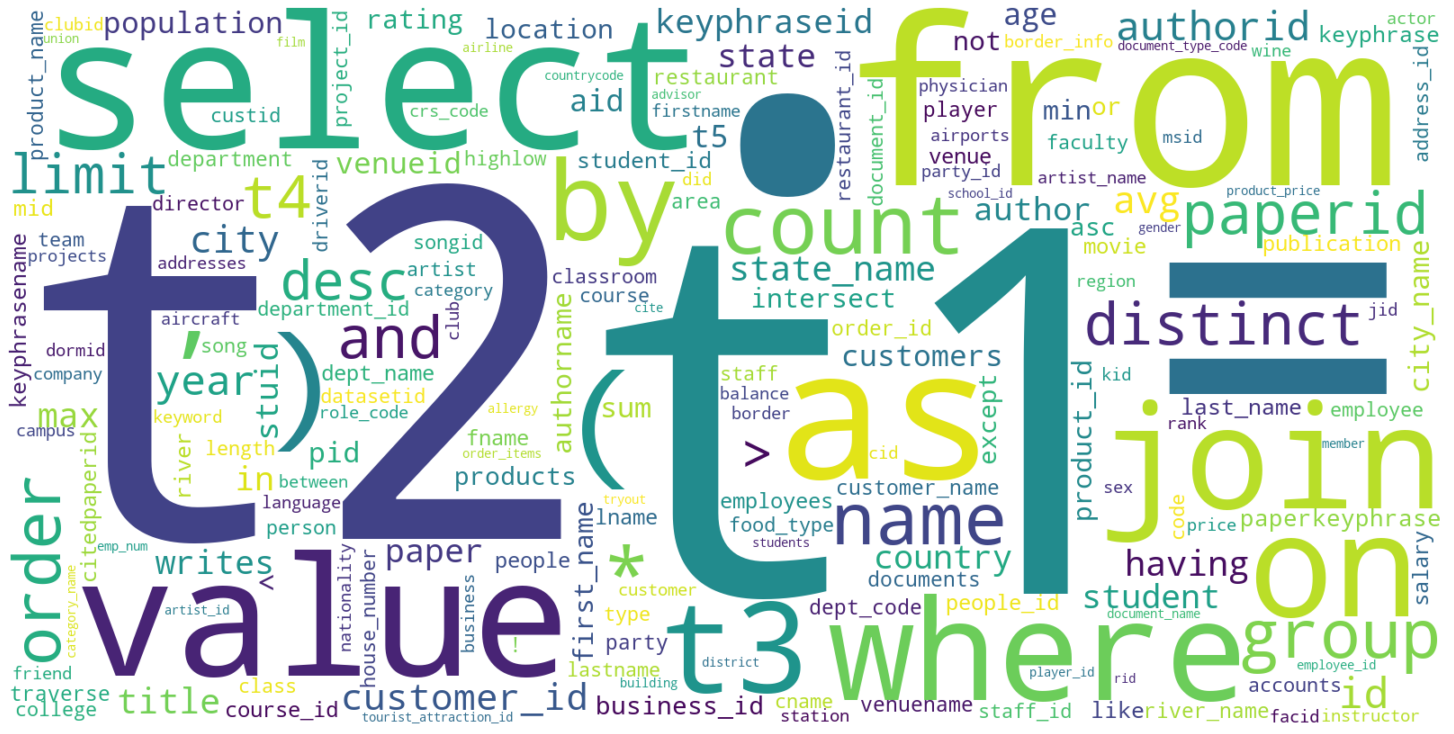

In [156]:
wc = WordCloud(background_color='white', width=1600, height=800).generate_from_frequencies(all_query_toks.value_counts().to_dict())
plt.figure(figsize=(20, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)